This notebook computes **data-driven session-gap thresholds** (inactivity time) for:

- **Target:** MARS (`events_target_norm.parquet`) — full analysis
- **Source:** XuetangX (`events_source_norm.parquet`) — gap analysis on deterministic user sample (scales)

It also produces **threshold sensitivity** tables (how many sessions / singleton sessions / avg session length at each threshold).

## Stable downstream output
Writes: `data/processed/normalized_events/session_gap_thresholds.json`


In [1]:
# [CELL 04-00] Environment + versions

import sys, json, platform
from pathlib import Path
from datetime import datetime, date

import pandas as pd
import numpy as np

import duckdb
from IPython.display import display

print("[04-00] Python:", sys.version)
print("[04-00] Platform:", platform.platform())
print("[04-00] pandas:", pd.__version__)
print("[04-00] duckdb:", duckdb.__version__)
print("[04-00] CWD:", Path.cwd().resolve())


[04-00] Python: 3.11.14 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 18:30:03) [MSC v.1929 64 bit (AMD64)]
[04-00] Platform: Windows-10-10.0.22621-SP0
[04-00] pandas: 2.3.3
[04-00] duckdb: 1.4.3
[04-00] CWD: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\notebooks


In [2]:
# [CELL 04-01] Bootstrap: locate repo root reliably (Windows-safe)

CWD = Path.cwd().resolve()
print("[04-01] Initial CWD:", CWD)

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "PROJECT_STATE.md").exists():
            print(f"[04-01] Found PROJECT_STATE.md in: {p}")
            return p
    for p in [start, *start.parents]:
        if (p / ".git").exists():
            print(f"[04-01] Found .git in: {p}")
            return p
    raise FileNotFoundError("Could not locate repo root (PROJECT_STATE.md or .git not found).")

REPO_ROOT = find_repo_root(CWD)

DATA_DIR      = REPO_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
REPORTS_DIR   = REPO_ROOT / "reports"

print("[04-01] REPO_ROOT:", REPO_ROOT)
print("[04-01] PROCESSED_DIR:", PROCESSED_DIR)
print("[04-01] REPORTS_DIR:", REPORTS_DIR)


[04-01] Initial CWD: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\notebooks
[04-01] Found PROJECT_STATE.md in: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta
[04-01] REPO_ROOT: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta
[04-01] PROCESSED_DIR: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed
[04-01] REPORTS_DIR: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports


In [3]:
# [CELL 04-02] Run config + helpers (JSON-safe)

RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_REPORT_DIR = REPORTS_DIR / "04_session_gap_and_timeline_analysis" / RUN_TAG
RUN_REPORT_DIR.mkdir(parents=True, exist_ok=True)

NORM_DIR = PROCESSED_DIR / "normalized_events"
TARGET_NORM = NORM_DIR / "events_target_norm.parquet"
SOURCE_NORM = NORM_DIR / "events_source_norm.parquet"

# Candidate thresholds (seconds) strict -> loose
CANDIDATES = [
    ("5m",  5*60),
    ("10m", 10*60),
    ("30m", 30*60),
    ("60m", 60*60),
    ("6h",  6*3600),
    ("12h", 12*3600),
    ("24h", 24*3600),
]

# Coverage rule: choose smallest threshold where coverage >= this value
COVERAGE_TARGET = 0.80

# Source sampling (deterministic), for tractability
SAMPLE_MOD = 100           # ~1% of users among users with >= 2 events
MIN_EVENTS_PER_USER = 2

print("[04-02] RUN_TAG:", RUN_TAG)
print("[04-02] RUN_REPORT_DIR:", RUN_REPORT_DIR)
print("[04-02] TARGET_NORM:", TARGET_NORM)
print("[04-02] SOURCE_NORM:", SOURCE_NORM)
print("[04-02] COVERAGE_TARGET:", COVERAGE_TARGET)
print("[04-02] SAMPLE_MOD:", SAMPLE_MOD, f"-> ~{100/SAMPLE_MOD:.1f}% of users")
print("[04-02] MIN_EVENTS_PER_USER:", MIN_EVENTS_PER_USER)

def _jsonify(x):
    if isinstance(x, (pd.Timestamp, datetime, date)):
        return x.isoformat()
    if isinstance(x, (np.integer,)):
        return int(x)
    if isinstance(x, (np.floating,)):
        return float(x)
    if isinstance(x, (np.bool_,)):
        return bool(x)
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, dict):
        return {str(k): _jsonify(v) for k, v in x.items()}
    if isinstance(x, (list, tuple)):
        return [_jsonify(v) for v in x]
    if x is pd.NA:
        return None
    return x

def save_json_safe(path: Path, obj: dict):
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(json.dumps(_jsonify(obj), indent=2, ensure_ascii=False), encoding="utf-8")
    print("[04-02] Wrote JSON:", path)

def save_df_csv(path: Path, df: pd.DataFrame, index=False):
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=index)
    print("[04-02] Wrote CSV:", path, "| shape:", df.shape)

save_json_safe(RUN_REPORT_DIR / "run_meta.json", {
    "run_tag": RUN_TAG,
    "created_at": datetime.now().isoformat(timespec="seconds"),
    "target_norm": str(TARGET_NORM),
    "source_norm": str(SOURCE_NORM),
    "candidates": CANDIDATES,
    "coverage_target": float(COVERAGE_TARGET),
    "source_sampling": {
        "SAMPLE_MOD": int(SAMPLE_MOD),
        "MIN_EVENTS_PER_USER": int(MIN_EVENTS_PER_USER)
    }
})

con = duckdb.connect(database=":memory:")
con.execute("PRAGMA threads=8;")


[04-02] RUN_TAG: 20251229_154018
[04-02] RUN_REPORT_DIR: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018
[04-02] TARGET_NORM: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\normalized_events\events_target_norm.parquet
[04-02] SOURCE_NORM: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\normalized_events\events_source_norm.parquet
[04-02] COVERAGE_TARGET: 0.8
[04-02] SAMPLE_MOD: 100 -> ~1.0% of users
[04-02] MIN_EVENTS_PER_USER: 2
[04-02] Wrote JSON: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\run_meta.json


In [4]:
# [CELL 04-03] TARGET load + schema + counts

assert TARGET_NORM.exists(), f"Missing: {TARGET_NORM}"
con.execute(f"CREATE OR REPLACE VIEW tgt AS SELECT * FROM read_parquet('{str(TARGET_NORM)}');")

tgt_schema = con.execute("DESCRIBE SELECT * FROM tgt;").df()
tgt_counts = con.execute("""
SELECT
  COUNT(*) AS n_events,
  COUNT(DISTINCT user_id) AS n_users,
  COUNT(DISTINCT item_id) AS n_items,
  MIN(timestamp) AS min_ts,
  MAX(timestamp) AS max_ts
FROM tgt;
""").df()

print("[04-03] tgt schema:")
display(tgt_schema)
print("[04-03] tgt counts:")
display(tgt_counts)

save_df_csv(RUN_REPORT_DIR / "tgt_schema.csv", tgt_schema)
save_df_csv(RUN_REPORT_DIR / "tgt_counts.csv", tgt_counts)


[04-03] tgt schema:


,column_name,column_type,null,key,default,extra
0,user_id,VARCHAR,YES,None,None,None
1,item_id,VARCHAR,YES,None,None,None
2,timestamp,TIMESTAMP,YES,None,None,None
3,signal_type,VARCHAR,YES,None,None,None
4,value,DOUBLE,YES,None,None,None


[04-03] tgt counts:


,n_events,n_users,n_items,min_ts,max_ts
0,3655,822,776,2018-09-28 14:38:15,2021-09-20 16:26:06


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\tgt_schema.csv | shape: (5, 6)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\tgt_counts.csv | shape: (1, 5)


In [5]:
# [CELL 04-04] TARGET gap analysis

print("\n" + "="*70)
print("04-04 INTER-EVENT GAP ANALYSIS (TARGET)")
print("="*70)

tgt_users = con.execute("""
WITH per_user AS (
  SELECT user_id, COUNT(*) AS n
  FROM tgt
  GROUP BY 1
)
SELECT
  COUNT(*) AS total_users,
  SUM(CASE WHEN n >= 2 THEN 1 ELSE 0 END) AS users_2plus,
  SUM(CASE WHEN n >= 5 THEN 1 ELSE 0 END) AS users_5plus,
  SUM(CASE WHEN n >= 10 THEN 1 ELSE 0 END) AS users_10plus
FROM per_user;
""").df()
display(tgt_users)
save_df_csv(RUN_REPORT_DIR / "tgt_users_by_events.csv", tgt_users)

con.execute("DROP VIEW IF EXISTS tgt_gaps;")
con.execute("""
CREATE OR REPLACE VIEW tgt_gaps AS
WITH ordered AS (
  SELECT
    user_id,
    timestamp,
    LAG(timestamp) OVER (PARTITION BY user_id ORDER BY timestamp) AS prev_ts
  FROM tgt
)
SELECT
  user_id,
  timestamp,
  prev_ts,
  EXTRACT(EPOCH FROM (timestamp - prev_ts)) AS gap_seconds
FROM ordered
WHERE prev_ts IS NOT NULL;
""")

tgt_gap_summary = con.execute("""
SELECT
  COUNT(*) AS n_gaps,
  MIN(gap_seconds) AS min_gap_s,
  MAX(gap_seconds) AS max_gap_s,
  AVG(gap_seconds) AS avg_gap_s,
  approx_quantile(gap_seconds, [0.5, 0.75, 0.9, 0.95, 0.99]) AS q
FROM tgt_gaps;
""").df()

tgt_gap_buckets = con.execute(
    "SELECT " + ", ".join([
        f"SUM(CASE WHEN gap_seconds <= {sec} THEN 1 ELSE 0 END) AS le_{label}"
        for label, sec in CANDIDATES
    ]) + ", COUNT(*) AS total_gaps FROM tgt_gaps;"
).df()

print("[04-04] tgt gap summary:")
display(tgt_gap_summary)
print("[04-04] tgt gap buckets:")
display(tgt_gap_buckets)

save_df_csv(RUN_REPORT_DIR / "tgt_gap_summary_seconds.csv", tgt_gap_summary)
save_df_csv(RUN_REPORT_DIR / "tgt_gap_buckets.csv", tgt_gap_buckets)



04-04 INTER-EVENT GAP ANALYSIS (TARGET)


,total_users,users_2plus,users_5plus,users_10plus
0,822,426.0,164.0,73.0


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\tgt_users_by_events.csv | shape: (1, 4)
[04-04] tgt gap summary:


,n_gaps,min_gap_s,max_gap_s,avg_gap_s,q
0,2833,1.0,73784739.0,766131.444052,"[201.3268035190616, 588.2793774731487, 177890...."


[04-04] tgt gap buckets:


,le_5m,le_10m,le_30m,le_60m,le_6h,le_12h,le_24h,total_gaps
0,1819.0,2132.0,2333.0,2380.0,2472.0,2481.0,2527.0,2833


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\tgt_gap_summary_seconds.csv | shape: (1, 5)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\tgt_gap_buckets.csv | shape: (1, 8)



04-05 DAILY EVENT VOLUME (TARGET)
[04-05] Daily rows: (595, 2)


,day,n
0,2018-09-28,44
1,2018-09-29,2
2,2018-10-01,1
3,2018-10-02,2
4,2018-10-04,30


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\tgt_daily_event_volume.csv | shape: (595, 2)


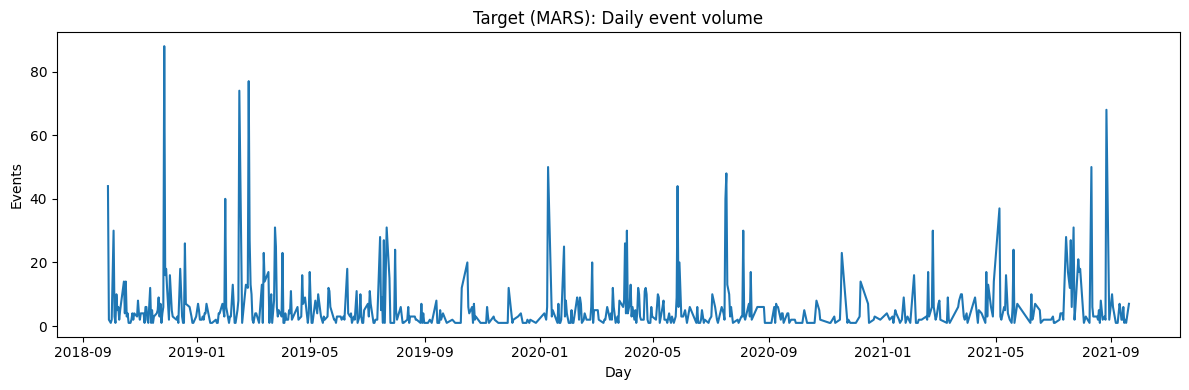

[04-05] Saved plot: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\tgt_daily_event_volume.png


In [6]:
# [CELL 04-05] TARGET daily volume plot

print("\n" + "="*70)
print("04-05 DAILY EVENT VOLUME (TARGET)")
print("="*70)

daily_tgt = con.execute("""
SELECT
  CAST(date_trunc('day', timestamp) AS DATE) AS day,
  COUNT(*) AS n
FROM tgt
GROUP BY 1
ORDER BY 1;
""").df()

print("[04-05] Daily rows:", daily_tgt.shape)
display(daily_tgt.head())

save_df_csv(RUN_REPORT_DIR / "tgt_daily_event_volume.csv", daily_tgt)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(daily_tgt["day"], daily_tgt["n"])
plt.title("Target (MARS): Daily event volume")
plt.xlabel("Day")
plt.ylabel("Events")
plt.tight_layout()

out_png = RUN_REPORT_DIR / "tgt_daily_event_volume.png"
plt.savefig(out_png, dpi=160)
plt.show()
print("[04-05] Saved plot:", out_png)


In [7]:
# [CELL 04-06] TARGET recommended threshold (coverage rule)

print("\n" + "="*70)
print("04-06 RECOMMENDED SESSION GAP (TARGET)")
print("="*70)

tb = tgt_gap_buckets.iloc[0].to_dict()
total = float(tb["total_gaps"]) if float(tb["total_gaps"]) > 0 else 1.0

coverage = {label: float(tb[f"le_{label}"]) / total for label, _ in CANDIDATES}

primary_label, primary_seconds = None, None
for label, sec in CANDIDATES:
    if coverage[label] >= COVERAGE_TARGET:
        primary_label, primary_seconds = label, sec
        break
if primary_label is None:
    primary_label, primary_seconds = CANDIDATES[-1]

recommended_target = {
    "dataset": "target_mars",
    "primary_threshold_label": primary_label,
    "primary_threshold_seconds": int(primary_seconds),
    "coverage_target": float(COVERAGE_TARGET),
    "coverage_by_candidate": coverage,
    "gap_summary": tgt_gap_summary.to_dict(orient="records")[0],
}

save_json_safe(RUN_REPORT_DIR / "recommended_thresholds_target.json", recommended_target)

print("[04-06] TARGET primary threshold:", primary_label, f"({primary_seconds}s)",
      "| coverage:", f"{coverage[primary_label]*100:.1f}%")



04-06 RECOMMENDED SESSION GAP (TARGET)
[04-02] Wrote JSON: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\recommended_thresholds_target.json
[04-06] TARGET primary threshold: 30m (1800s) | coverage: 82.4%


In [8]:
# [CELL 04-07] SOURCE load + schema + counts

print("\n" + "="*70)
print("04-07 SOURCE LOAD + COUNTS")
print("="*70)

assert SOURCE_NORM.exists(), f"Missing: {SOURCE_NORM}"
con.execute(f"CREATE OR REPLACE VIEW src AS SELECT * FROM read_parquet('{str(SOURCE_NORM)}');")

src_schema = con.execute("DESCRIBE SELECT * FROM src;").df()
src_counts = con.execute("""
SELECT
  COUNT(*) AS n_events,
  COUNT(DISTINCT user_id) AS n_users,
  COUNT(DISTINCT item_id) AS n_items,
  MIN(timestamp) AS min_ts,
  MAX(timestamp) AS max_ts
FROM src;
""").df()

display(src_schema)
display(src_counts)

save_df_csv(RUN_REPORT_DIR / "src_schema.csv", src_schema)
save_df_csv(RUN_REPORT_DIR / "src_counts.csv", src_counts)



04-07 SOURCE LOAD + COUNTS


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,column_name,column_type,null,key,default,extra
0,user_id,VARCHAR,YES,None,None,None
1,item_id,VARCHAR,YES,None,None,None
2,timestamp,TIMESTAMP,YES,None,None,None
3,signal_type,VARCHAR,YES,None,None,None
4,value,DOUBLE,YES,None,None,None


,n_events,n_users,n_items,min_ts,max_ts
0,154817413,770283,1628,2015-07-31 23:59:15,2017-07-31 23:59:09


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\src_schema.csv | shape: (5, 6)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\src_counts.csv | shape: (1, 5)


In [9]:
# [CELL 04-08] SOURCE deterministic sampling (users) + src_sample view

print("\n" + "="*70)
print("04-08 SOURCE USER SAMPLE (DETERMINISTIC)")
print("="*70)

con.execute("DROP VIEW IF EXISTS src_user_counts;")
con.execute("""
CREATE OR REPLACE VIEW src_user_counts AS
SELECT user_id, COUNT(*) AS n_events
FROM src
GROUP BY 1;
""")

src_user_summary = con.execute("""
SELECT
  COUNT(*) AS total_users,
  SUM(CASE WHEN n_events >= 2 THEN 1 ELSE 0 END) AS users_2plus,
  SUM(CASE WHEN n_events >= 5 THEN 1 ELSE 0 END) AS users_5plus,
  approx_quantile(n_events, [0.5, 0.9, 0.99]) AS n_events_q
FROM src_user_counts;
""").df()
display(src_user_summary)

con.execute("DROP TABLE IF EXISTS src_sample_users;")
con.execute(f"""
CREATE TABLE src_sample_users AS
SELECT user_id
FROM src_user_counts
WHERE n_events >= {MIN_EVENTS_PER_USER}
  AND (abs(hash(user_id)) % {SAMPLE_MOD}) = 0;
""")

sample_n = con.execute("SELECT COUNT(*) AS n_sample_users FROM src_sample_users;").df()
display(sample_n)

con.execute("DROP VIEW IF EXISTS src_sample;")
con.execute("""
CREATE OR REPLACE VIEW src_sample AS
SELECT s.*
FROM src s
SEMI JOIN src_sample_users u
ON s.user_id = u.user_id;
""")

src_sample_counts = con.execute("""
SELECT
  COUNT(*) AS n_events,
  COUNT(DISTINCT user_id) AS n_users,
  COUNT(DISTINCT item_id) AS n_items,
  MIN(timestamp) AS min_ts,
  MAX(timestamp) AS max_ts
FROM src_sample;
""").df()
display(src_sample_counts)

save_df_csv(RUN_REPORT_DIR / "src_user_summary.csv", src_user_summary)
save_df_csv(RUN_REPORT_DIR / "src_sample_users_count.csv", sample_n)
save_df_csv(RUN_REPORT_DIR / "src_sample_counts.csv", src_sample_counts)



04-08 SOURCE USER SAMPLE (DETERMINISTIC)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,total_users,users_2plus,users_5plus,n_events_q
0,770283,686129.0,558676.0,"[20, 504, 2688]"


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_sample_users
0,6891


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_events,n_users,n_items,min_ts,max_ts
0,1698038,6891,1476,2015-07-31 23:59:21,2017-07-31 23:51:34


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\src_user_summary.csv | shape: (1, 4)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\src_sample_users_count.csv | shape: (1, 1)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\src_sample_counts.csv | shape: (1, 5)


In [10]:
# [CELL 04-09] SOURCE gap analysis (sampled)

print("\n" + "="*70)
print("04-09 INTER-EVENT GAP ANALYSIS (SOURCE — SAMPLED USERS)")
print("="*70)

con.execute("DROP VIEW IF EXISTS src_gaps;")
con.execute("""
CREATE OR REPLACE VIEW src_gaps AS
WITH ordered AS (
  SELECT
    user_id,
    timestamp,
    LAG(timestamp) OVER (PARTITION BY user_id ORDER BY timestamp) AS prev_ts
  FROM src_sample
)
SELECT
  user_id,
  timestamp,
  prev_ts,
  EXTRACT(EPOCH FROM (timestamp - prev_ts)) AS gap_seconds
FROM ordered
WHERE prev_ts IS NOT NULL;
""")

src_gap_summary = con.execute("""
SELECT
  COUNT(*) AS n_gaps,
  MIN(gap_seconds) AS min_gap_s,
  MAX(gap_seconds) AS max_gap_s,
  AVG(gap_seconds) AS avg_gap_s,
  approx_quantile(gap_seconds, [0.5, 0.75, 0.9, 0.95, 0.99]) AS q
FROM src_gaps;
""").df()

src_gap_buckets = con.execute(
    "SELECT " + ", ".join([
        f"SUM(CASE WHEN gap_seconds <= {sec} THEN 1 ELSE 0 END) AS le_{label}"
        for label, sec in CANDIDATES
    ]) + ", COUNT(*) AS total_gaps FROM src_gaps;"
).df()

display(src_gap_summary)
display(src_gap_buckets)

save_df_csv(RUN_REPORT_DIR / "src_gap_summary_seconds_sampled.csv", src_gap_summary)
save_df_csv(RUN_REPORT_DIR / "src_gap_buckets_sampled.csv", src_gap_buckets)



04-09 INTER-EVENT GAP ANALYSIS (SOURCE — SAMPLED USERS)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_gaps,min_gap_s,max_gap_s,avg_gap_s,q
0,1691147,0.0,58243156.0,25025.657822,"[4.999804430274764, 36.87269163578986, 260.085..."


,le_5m,le_10m,le_30m,le_60m,le_6h,le_12h,le_24h,total_gaps
0,1536527.0,1592937.0,1631315.0,1640559.0,1654544.0,1658707.0,1667130.0,1691147


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\src_gap_summary_seconds_sampled.csv | shape: (1, 5)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\src_gap_buckets_sampled.csv | shape: (1, 8)


In [11]:
# [CELL 04-10] SOURCE recommended threshold (coverage rule)

print("\n" + "="*70)
print("04-10 RECOMMENDED SESSION GAP (SOURCE — SAMPLED)")
print("="*70)

sb = src_gap_buckets.iloc[0].to_dict()
total = float(sb["total_gaps"]) if float(sb["total_gaps"]) > 0 else 1.0

coverage = {label: float(sb[f"le_{label}"]) / total for label, _ in CANDIDATES}

primary_label, primary_seconds = None, None
for label, sec in CANDIDATES:
    if coverage[label] >= COVERAGE_TARGET:
        primary_label, primary_seconds = label, sec
        break
if primary_label is None:
    primary_label, primary_seconds = CANDIDATES[-1]

recommended_source = {
    "dataset": "source_xuetangx_sampled",
    "primary_threshold_label": primary_label,
    "primary_threshold_seconds": int(primary_seconds),
    "coverage_target": float(COVERAGE_TARGET),
    "coverage_by_candidate": coverage,
    "gap_summary_sampled": src_gap_summary.to_dict(orient="records")[0],
    "sampling": {
        "SAMPLE_MOD": int(SAMPLE_MOD),
        "MIN_EVENTS_PER_USER": int(MIN_EVENTS_PER_USER),
        "sample_users": int(sample_n.iloc[0]["n_sample_users"]),
        "sample_counts": src_sample_counts.to_dict(orient="records")[0],
    },
}

save_json_safe(RUN_REPORT_DIR / "recommended_thresholds_source.json", recommended_source)

print("[04-10] SOURCE primary threshold:", primary_label, f"({primary_seconds}s)",
      "| coverage:", f"{coverage[primary_label]*100:.1f}%")



04-10 RECOMMENDED SESSION GAP (SOURCE — SAMPLED)
[04-02] Wrote JSON: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\recommended_thresholds_source.json
[04-10] SOURCE primary threshold: 5m (300s) | coverage: 90.9%


In [12]:
# [CELL 04-11] Threshold sensitivity: session outcomes at multiple thresholds

print("\n" + "="*70)
print("04-11 THRESHOLD SENSITIVITY (SESSIONS OUTCOME)")
print("="*70)

def session_stats(view_name: str, gap_seconds: int) -> dict:
    con.execute("DROP VIEW IF EXISTS _sess_events;")
    con.execute(f"""
    CREATE OR REPLACE VIEW _sess_events AS
    WITH ordered AS (
      SELECT
        user_id,
        timestamp,
        LAG(timestamp) OVER (PARTITION BY user_id ORDER BY timestamp) AS prev_ts
      FROM {view_name}
    ),
    flags AS (
      SELECT
        *,
        CASE
          WHEN prev_ts IS NULL THEN 1
          WHEN EXTRACT(EPOCH FROM (timestamp - prev_ts)) > {gap_seconds} THEN 1
          ELSE 0
        END AS is_new_session
      FROM ordered
    )
    SELECT
      user_id,
      timestamp,
      SUM(is_new_session) OVER (PARTITION BY user_id ORDER BY timestamp) AS session_num
    FROM flags;
    """)

    sess = con.execute("""
    WITH s AS (
      SELECT user_id, session_num, COUNT(*) AS session_len
      FROM _sess_events
      GROUP BY 1,2
    )
    SELECT
      COUNT(*) AS n_sessions,
      AVG(session_len) AS avg_len,
      approx_quantile(session_len, [0.5, 0.9, 0.99]) AS len_q,
      SUM(CASE WHEN session_len = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS pct_singleton
    FROM s;
    """).df().iloc[0].to_dict()

    spu = con.execute("""
    WITH u AS (
      SELECT user_id, COUNT(DISTINCT session_num) AS n_sessions
      FROM _sess_events
      GROUP BY 1
    )
    SELECT
      approx_quantile(n_sessions, [0.5, 0.9, 0.99]) AS sessions_per_user_q,
      AVG(n_sessions) AS avg_sessions_per_user
    FROM u;
    """).df().iloc[0].to_dict()

    return {"session_summary": sess, "sessions_per_user": spu}

def sensitivity(view_name: str, thresholds: list[int], label: str) -> pd.DataFrame:
    rows = []
    for sec in thresholds:
        st = session_stats(view_name, sec)
        rows.append({
            "dataset": label,
            "threshold_s": int(sec),
            "threshold_label": f"{int(sec//60)}m" if sec < 3600 else f"{int(sec//3600)}h",
            "n_sessions": st["session_summary"]["n_sessions"],
            "avg_len": st["session_summary"]["avg_len"],
            "pct_singleton": st["session_summary"]["pct_singleton"],
            "len_q": st["session_summary"]["len_q"],
            "sessions_per_user_q": st["sessions_per_user"]["sessions_per_user_q"],
            "avg_sessions_per_user": st["sessions_per_user"]["avg_sessions_per_user"],
        })
    return pd.DataFrame(rows)

target_sens = sensitivity("tgt", [10*60, 30*60, 60*60, 6*3600], "target_mars")
source_sens = sensitivity("src_sample", [10*60, 30*60, 60*60], "source_xuetangx_sampled")

print("[04-11] Target sensitivity:")
display(target_sens)
print("[04-11] Source sensitivity (sampled):")
display(source_sens)

save_df_csv(RUN_REPORT_DIR / "target_threshold_sensitivity.csv", target_sens)
save_df_csv(RUN_REPORT_DIR / "source_threshold_sensitivity.csv", source_sens)



04-11 THRESHOLD SENSITIVITY (SESSIONS OUTCOME)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[04-11] Target sensitivity:


,dataset,threshold_s,threshold_label,n_sessions,avg_len,pct_singleton,len_q,sessions_per_user_q,avg_sessions_per_user
0,target_mars,600,10m,1523,2.399869,0.611950,"[1, 5, 18]","[1, 3, 12]",1.852798
1,target_mars,1800,30m,1322,2.764750,0.575643,"[1, 6, 25]","[1, 3, 9]",1.608273
2,target_mars,3600,1h,1275,2.866667,0.569412,"[1, 6, 27]","[1, 3, 8]",1.551095
3,target_mars,21600,6h,1183,3.089603,0.556213,"[1, 6, 30]","[1, 2, 6]",1.439173


[04-11] Source sensitivity (sampled):


,dataset,threshold_s,threshold_label,n_sessions,avg_len,pct_singleton,len_q,sessions_per_user_q,avg_sessions_per_user
0,source_xuetangx_sampled,600,10m,105101,16.156250,0.159894,"[7, 36, 131]","[3, 37, 199]",15.251923
1,source_xuetangx_sampled,1800,30m,66723,25.449066,0.138363,"[10, 61, 193]","[2, 23, 115]",9.682630
2,source_xuetangx_sampled,3600,1h,57479,29.541885,0.119331,"[12, 70, 222]","[2, 19, 94]",8.341170


[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\target_threshold_sensitivity.csv | shape: (4, 9)
[04-02] Wrote CSV: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\reports\04_session_gap_and_timeline_analysis\20251229_154018\source_threshold_sensitivity.csv | shape: (3, 9)


In [13]:
# [CELL 04-12] Save stable thresholds for Notebook 05

print("\n" + "="*70)
print("04-12 WRITE STABLE THRESHOLDS (DOWNSTREAM INPUT)")
print("="*70)

rt = json.loads((RUN_REPORT_DIR / "recommended_thresholds_target.json").read_text(encoding="utf-8"))
rs = json.loads((RUN_REPORT_DIR / "recommended_thresholds_source.json").read_text(encoding="utf-8"))

stable = {
    "generated_from_run_tag": RUN_TAG,
    "generated_at": datetime.now().isoformat(timespec="seconds"),
    "target": {
        "primary_threshold_seconds": int(rt["primary_threshold_seconds"]),
        "primary_threshold_label": rt["primary_threshold_label"],
    },
    "source": {
        "primary_threshold_seconds": int(rs["primary_threshold_seconds"]),
        "primary_threshold_label": rs["primary_threshold_label"],
        "sampling": rs.get("sampling", {})
    }
}

stable_path = NORM_DIR / "session_gap_thresholds.json"
save_json_safe(stable_path, stable)

print("[04-12] Wrote:", stable_path)
print("[04-12] Target:", stable["target"])
print("[04-12] Source:", stable["source"])



04-12 WRITE STABLE THRESHOLDS (DOWNSTREAM INPUT)
[04-02] Wrote JSON: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\normalized_events\session_gap_thresholds.json
[04-12] Wrote: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\normalized_events\session_gap_thresholds.json
[04-12] Target: {'primary_threshold_seconds': 1800, 'primary_threshold_label': '30m'}
[04-12] Source: {'primary_threshold_seconds': 300, 'primary_threshold_label': '5m', 'sampling': {'SAMPLE_MOD': 100, 'MIN_EVENTS_PER_USER': 2, 'sample_users': 6891, 'sample_counts': {'n_events': 1698038, 'n_users': 6891, 'n_items': 1476, 'min_ts': '2015-07-31T23:59:21', 'max_ts': '2017-07-31T23:51:34'}}}
